# Doc2Vec (Figures 3, 4 and Tables 3, 4)

adapted (partially) from https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/doc2vec-IMDB.ipynb

In [1]:
import json
import re
from collections import namedtuple

import gensim

train = False

Document = namedtuple('Document', 'words tags')

alldocs = []  # will hold all docs in original order
with open('../data/c_twitter.json') as f_in:
    for i, line in enumerate(f_in):
        c_twt = json.loads(line)
        # c_twt: {'weeknum': str, 'c_text': str, 'tags': [str]}
        words = c_twt['text'].split()
        tags = [str(c_twt['id'])] + c_twt['tags']
        alldocs.append(Document(words, tags))
        
shuffle_docs = alldocs[:]
print('number of tweets:', len(alldocs))

number of tweets: 624569


In [2]:
def twt_gen():
    with open('../data/c_twitter.json') as f_in:
        for line in f_in:
            c_twt = json.loads(line)
            if 'coordinates' in c_twt:
                yield c_twt
            
geo_twts = list(twt_gen())
print('number of geo-tweets:', len(geo_twts))

number of geo-tweets: 14204


/high_spd_work/sm_w2v/venv/lib/python3.4/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in log10


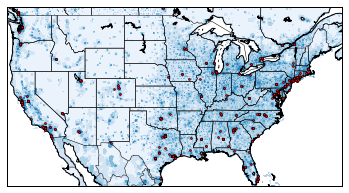

In [3]:
import numpy as np

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

pop_data = np.loadtxt('glds00g.asc', skiprows=6)

xo = np.arange(-180,180,0.0416666666667)
yo = np.arange(-58,85,0.0416666666667)
xx,yy = np.meshgrid(xo,yo,indexing='xy')

fig = plt.figure()
ax = fig.add_subplot(111)
m = Basemap(projection='merc',
    resolution = 'l',
    llcrnrlon=-125.0, llcrnrlat=25.0,
    urcrnrlon=-65.0, urcrnrlat=50.0,
    ax=ax)
xm, ym = m(xx,yy)

# plot population density
m.contourf(xm, ym, np.log10(pop_data[::-1, :] +1), cmap=plt.cm.Blues)
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# plot HIV/PrEP geo tweets
lons = [twt['coordinates'][0] for twt in geo_twts]
lats = [twt['coordinates'][1] for twt in geo_twts]
x,y = m(lons, lats)
m.plot(x, y, 'ro', markersize=2)

plt.show()
fig = ax.get_figure()
fig.savefig('map.pdf', format='pdf')

# Build model and train (or load model from file)

In [5]:
import multiprocessing
from random import shuffle
import random
import time

from gensim.models import Doc2Vec
import gensim.models.doc2vec

import numpy as np

random.seed(1)
np.random.seed(1)



if train:
    cores = multiprocessing.cpu_count()
    assert gensim.models.doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"

    # PV-DM w/average
    model= Doc2Vec(dm=1, dm_mean=1, size=100, window=3, negative=5, hs=0, min_count=2, workers=cores,
               max_vocab_size=10000, seed=1)


    # the array is too big
    model.build_vocab(alldocs)
    print("model:", model)

    # train model
    passes = 15
    start_time = time.time()

    for epoch in range(passes):
        shuffle(shuffle_docs)
        model.train(shuffle_docs)
        print(epoch, model.most_similar('hiv', topn=10))

        # do some validation after each epoch
        doc_ids = random.sample(range(len(alldocs)), 1000)
        score = 0
        for doc_id in doc_ids:
            inferred_docvec = model.infer_vector(alldocs[doc_id].words)
            score += sum(abs(model.docvecs[doc_id] - inferred_docvec))
        print("--- score: ", score)
        print("ELAPSED TIME (seconds): ", time.time() - start_time)

    model.save('../models/doc2vec.model')
else:
    model = Doc2Vec.load('../models/doc2vec.model')

# Table 4: Related Word-Vectors

In [6]:
import pandas as pd
new_vecs = model.most_similar(['HIVAIDS'], topn=10)
df_hivaids = pd.DataFrame(data=new_vecs, columns=['Related-Word', 'Cosine Similarity to \"HIVAIDS\"'])
df_hivaids

,Related-Word,"Cosine Similarity to ""HIVAIDS"""
0,HIV,0.818911
1,HIVAids,0.724947
2,CommunityHealthWorkers,0.699273
3,AIDS,0.690322
4,hiv,0.677404
5,HIV',0.649427
6,MartinSheen,0.636286
7,___,0.631384
8,ValentinesDay,0.627035
9,POZ100,0.610208


In [7]:
new_vecs = model.most_similar(['PrEP'], topn=10)
df_prep = pd.DataFrame(data=new_vecs, columns=['Related Word', 'Cosine Similarity to \"PrEP\"'])
df_prep

,Related Word,"Cosine Similarity to ""PrEP"""
0,truvada,0.796666
1,Truvada,0.793999
2,DoingIt,0.738141
3,WorldAidsDay,0.728808
4,WorldAIDSDay,0.720910
5,NancyReagan,0.717667
6,NBHAAD,0.705061
7,ART,0.704300
8,hiv,0.702844
9,HLM2016AIDS,0.698698


In [8]:
new_vecs = model.most_similar(['Prophylaxis'], topn=10)
df_prophylaxis = pd.DataFrame(data=new_vecs, columns=['Related Word', 'Cosine Similarity to \"Prophylaxis\"'])
df_prophylaxis

,Related Word,"Cosine Similarity to ""Prophylaxis"""
0,Therapy,0.589653
1,Infection,0.575552
2,Care,0.534470
3,Prevalence,0.533740
4,Transmission,0.528449
5,Undetectable,0.526384
6,Cure,0.520077
7,Battle,0.513951
8,Testing,0.513583
9,Meds,0.509417


In [9]:
new_vecs = model.most_similar(['Truvada'], topn=10)
df_truvada = pd.DataFrame(data=new_vecs, columns=['Related Word', 'Cosine Similarity to \"Truvada\"'])
df_truvada

,Related Word,"Cosine Similarity to ""Truvada"""
0,truvada,0.797425
1,PrEP,0.793999
2,NancyReagan,0.693513
3,ICASA2015,0.689682
4,DoingIt,0.689329
5,WorldAidsDay,0.679311
6,winning,0.646606
7,LIGHTWORK,0.642938
8,aids,0.641395
9,nutrition,0.639862


# Figure 3: PCA and tSNE plots of relevent word vectors

PCA explained variance ratio:  [ 0.07163029  0.05912598]


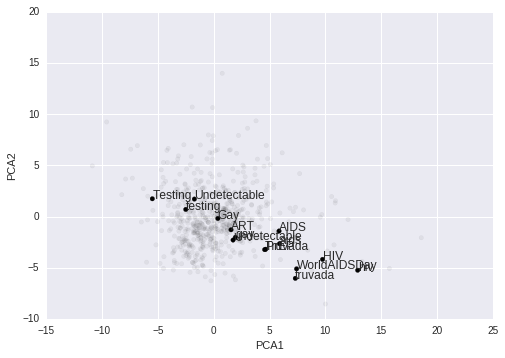

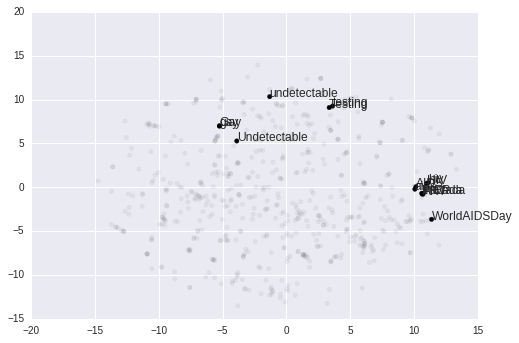

In [22]:
import sys

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# append path to my module
if '/high_spd_work/sm_w2v' not in sys.path:
    sys.path.append('/high_spd_work/sm_w2v')
from sm_w2v.plot_utils import scatter_plot

# come up with words that are relevent, but not too similar
related_words = ["PrEP", "AIDS", "aids", "HIV", "hiv", "gay", "Gay",
                 "Undetectable", "undetectable", "Testing", "testing",
                 "WorldAIDSDay", "WorldaidsDay", "ART", "genvoya",
                 "Genvoya", "truvada", "Truvada"]

# Prepare data matrix
X = []
text_annotations = []
for word in model.vocab:
    X.append(model[word])
    if word in related_words:
        text_annotations.append(word)
    else:
        text_annotations.append("")
X = np.array(X)

# Do k-means on original data matrix
kmeans = KMeans(n_clusters=1, random_state=1)
kmeans_labels = kmeans.fit_predict(X)

# Do PCA
pca = PCA(n_components=2, copy=True)
pca.fit(X)
print("PCA explained variance ratio: ", pca.explained_variance_ratio_)
pca_comps = pca.transform(X)

# Do tSNE
tsne = TSNE(n_components=2, random_state=2, perplexity=5.0)
tsne_comps = tsne.fit_transform(X)

# Scatter plot
rand_seed = 0
alpha_high = 1.0
alpha_low = 0.05
down_samp_rate = 0.1

# save PCA plot in 'notebooks' directory
##### doing manual plotting, lots of verbosity ##############
x=pca_comps[:,0]
y=pca_comps[:,1]
clust_labels=kmeans_labels
title='pca_words_prep'
plot_lims=None

# set up the high alpha labeled plot
txt_labels = []
x_high_alpha = []
y_high_alpha = []
labels_high_alpha = []
text_high_alpha = []
for i in range(len(x)):
    if(text_annotations[i] != ""):
        x_high_alpha.append(x[i])
        y_high_alpha.append(y[i])
        labels_high_alpha.append(clust_labels[i])
        text_high_alpha.append(text_annotations[i])

# do down sample
if(rand_seed):
    np.random.seed(rand_seed)
take = np.random.choice(list(range(len(x))), int(len(x)*down_samp_rate), replace=False)
x = np.array(x)[take]
y = np.array(y)[take]
clust_labels = np.array(clust_labels)[take]

# Plot all the data with low alpha (in the background)
fig, ax = plt.subplots()
ax.scatter(x, y, alpha=alpha_low, c=clust_labels, cmap=plt.get_cmap("nipy_spectral"))

# Plot data with high alpha
ax.scatter(x_high_alpha, y_high_alpha, c=labels_high_alpha,
        alpha=alpha_high, cmap=plt.get_cmap("nipy_spectral"))


for i, txt in enumerate(text_high_alpha):
    ax.annotate(txt, (x_high_alpha[i], y_high_alpha[i]))
if(plot_lims):
    plt.axis(plot_lims)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.savefig(title + ".pdf", format="pdf")
plt.show()

######## end manual plotting ##################################

# save tSNE plot in 'notebooks' directory
scatter_plot(tsne_comps[:,0], tsne_comps[:,1], alpha_high, alpha_low,
            kmeans_labels, text_annotations,
            down_samp_rate, "tsne_words_prep", rand_seed, None)

# Table 4: Related Hashtags and Tweets

Hashtags begin with "#", users begin with "user--" and tweets are just a number - that refers to the corresponding index in the "alldocs" variable, or the "../data/c_twitter.json" cleaned tweets file

In [11]:
new_vecs = model.docvecs.most_similar(['#truvada'], topn=100)
df_hash_truvada = pd.DataFrame(data=[v for v in new_vecs if '#' in v[0]][0:10],
                               columns=['Related Hashtag/User/Tweet', 'Cosine Similarity to \"#Truvada\"'])
df_hash_truvada

,Related Hashtag/User/Tweet,"Cosine Similarity to ""#Truvada"""
0,#prep,0.696113
1,#hiv,0.667790
2,#drug,0.598265
3,#genvoya,0.597513
4,#bethegeneration,0.580109
5,#grimm100,0.572392
6,#hivprevention,0.570144
7,#hivtesting,0.563599
8,#africa,0.562143
9,#hivawareness,0.554829


In [12]:
new_vecs = model.docvecs.most_similar(['#prep'], topn=10)
df_hash_prep = pd.DataFrame(data=new_vecs, columns=['Related Related Hashtag/User/Tweet', 'Cosine Similarity to \"#PrEP\"'])
df_hash_prep

,Related Related Hashtag/User/Tweet,"Cosine Similarity to ""#PrEP"""
0,#lgbtmedia16,0.739128
1,#hiv,0.727602
2,#whereisprep,0.707165
3,#truvada,0.696113
4,#hivprevention,0.636068
5,702179860983189504,0.630055
6,▫▫▫▫▫▫▫▫▫▫▫▫▫▫▫▫▫▫▫▫-*-711275699529764864,0.629254
7,708519265540907010,0.628778
8,712032637024653313,0.628646
9,#harrogatehour,0.628547


In [13]:
# tweet text
print(' '.join([doc for doc in alldocs if int(doc.tags[0]) == 702179860983189504][0][0]), '\n')
print(' '.join([doc for doc in alldocs if int(doc.tags[0]) == 708519265540907010][0][0]), '\n')
print(' '.join([doc for doc in alldocs if int(doc.tags[0]) == 712032637024653313][0][0]), '\n')

# StoneColdVideoTODAY if You see this 13 symptoms . Do HIV Test Immediately . Must Read 

Checkout why PrEP is hurting the cause amp # JoinTheConversation # LGBTQIA 

Increase Your foIIowershttpst . con31LbMVwoA PrEP # buyonlinehour # Panorama # northlondonhour # TheWalkingDeadUK # harrogatehour 



In [29]:
new_vecs = model.docvecs.most_similar(['#imtesting'], topn=10)
df_hash_imtesting = pd.DataFrame(data=new_vecs, columns=['Related Related Hashtag/User/Tweet', 'Cosine Similarity to \"#imtesting\"'])
df_hash_imtesting

,Related Related Hashtag/User/Tweet,"Cosine Similarity to ""#imtesting"""
0,#hiv,0.602702
1,#dchealthchat,0.564318
2,714760041136537600,0.559456
3,#lowcountryaids,0.551879
4,#numbersdontlie,0.551254
5,Clara Corsaro-*-436781723,0.551065
6,703576199189110784,0.551044
7,#uncg17,0.548889
8,#uncg18,0.548606
9,#uncg19,0.548591


# Figure 4: Related Hashtags and Tweets

PCA explained variance ratio:  [ 0.0641254   0.04009636]


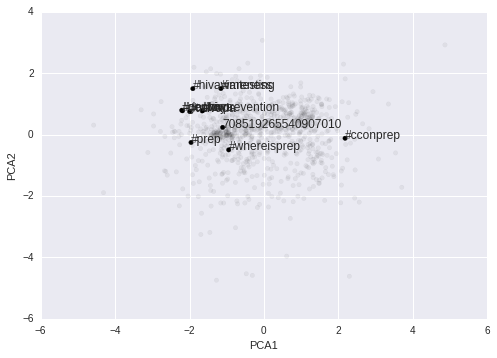

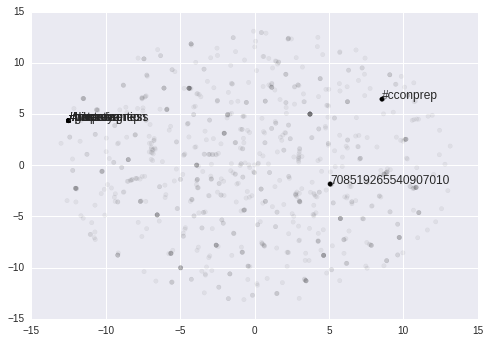

In [30]:
# related words from above
related_words = ["#hiv", "#imtesting", "#whereisprep", "#hivprevention", "#truvada",
                "#hivawareness", "#prep", "#genvoya", "708519265540907010", "#doctor",
                "#cconprep", "#jointheconversation"]


# Prepare data matrix
X = []
text_annotations = []
for i, word in enumerate(model.docvecs.doctags):
    if (i % 100 == 0 or word in related_words) :
        X.append(model.docvecs[word])
        if word in related_words:
            text_annotations.append(word)
        else:
            text_annotations.append("")
X = np.array(X)

# Do k-means on original data matrix
kmeans = KMeans(n_clusters=1, random_state=1)
kmeans_labels = kmeans.fit_predict(X)

# Do PCA
pca = PCA(n_components=2, copy=True)
pca.fit(X)
print("PCA explained variance ratio: ", pca.explained_variance_ratio_)
pca_comps = pca.transform(X)

# Do tSNE
tsne = TSNE(n_components=2, random_state=2, perplexity=1.0)
tsne_comps = tsne.fit_transform(X)

# Scatter plot

rand_seed = 0
alpha_high = 1.0
alpha_low = 0.05
down_samp_rate = 0.1

##### doing manual plotting, lots of verbosity ##############
x=pca_comps[:,0]
y=pca_comps[:,1]
clust_labels=kmeans_labels
title='pca_docs_prep'
plot_lims=None

# set up the high alpha labeled plot
txt_labels = []
x_high_alpha = []
y_high_alpha = []
labels_high_alpha = []
text_high_alpha = []
for i in range(len(x)):
    if(text_annotations[i] != ""):
        x_high_alpha.append(x[i])
        y_high_alpha.append(y[i])
        labels_high_alpha.append(clust_labels[i])
        text_high_alpha.append(text_annotations[i])

# do down sample
if(rand_seed):
    np.random.seed(rand_seed)
take = np.random.choice(list(range(len(x))), int(len(x)*down_samp_rate), replace=False)
x = np.array(x)[take]
y = np.array(y)[take]
clust_labels = np.array(clust_labels)[take]

# Plot all the data with low alpha (in the background)
fig, ax = plt.subplots()
ax.scatter(x, y, alpha=alpha_low, c=clust_labels, cmap=plt.get_cmap("nipy_spectral"))

# Plot data with high alpha
ax.scatter(x_high_alpha, y_high_alpha, c=labels_high_alpha,
        alpha=alpha_high, cmap=plt.get_cmap("nipy_spectral"))

for i, txt in enumerate(text_high_alpha):
    ax.annotate(txt, (x_high_alpha[i], y_high_alpha[i]))
if(plot_lims):
    plt.axis(plot_lims)

plt.xlabel('PCA1')
plt.ylabel('PCA2')

plt.savefig(title + ".pdf", format="pdf")
plt.show()

######## end manual plotting ##################################

# save tSNE plot in 'notebooks' directory (it won't show here in the notebook)
scatter_plot(tsne_comps[:,0], tsne_comps[:,1], alpha_high, alpha_low,
            kmeans_labels, text_annotations,
            down_samp_rate, "tsne_docs_prep", rand_seed, None)

# get ~24,000 users related to PrEP sorted

and store in '../data/top_users_to_PrEP.txt'


this is providing data for other notebook:

`topic_modeling_on_user-timelines.ipynb`

and was only run once:



In [17]:
# # get top 1000 user id strings and save for user-timeline analysis
# sim_vecs = model.docvecs.most_similar(['#prep'], topn=100000)
# users = []
# for v in sim_vecs:
#     l = v[0].split('-*-')
#     if len(l) > 1:
#         users.append(l[-1])

# with open('../data/top_users_to_PrEP.txt', 'w') as f_out:
#     f_out.write('\n'.join(users))
